In [1]:
import torch
import torch.nn.functional as f
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torchsummary import summary
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

## Data transformations

In [2]:
# Train data transformation

train_transforms = transforms.Compose([transforms.RandomRotation((-9.0, 9.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=(0.1307,), std=(0.3081,))
                                       ])
                                       

# Test transform

test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.1307,), std=(0.3081,))
                                      ])

## Dataset and creating Train/Test split

In [3]:
train = datasets.MNIST(root='../data', train=True, download=True, transform=train_transforms)

test = datasets.MNIST(root='../data', train=False, download=True, transform=test_transforms)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Dataloader arguments and train test dataloaders

In [4]:
torch.manual_seed(100)

In [5]:
cuda = torch.cuda.is_available()

if cuda:
  print('\n CUDA is available')
  torch.cuda.manual_seed(100)
else:
  print("\n No GPU")

  


 CUDA is available


In [6]:
WORKERS = 1
BATCH_SIZE = 128

In [7]:
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=WORKERS, pin_memory=True) if cuda\
 else dict(shuffle=True, batch_size=BATCH_SIZE)

In [8]:
# train dataloader 

train_loader = torch.utils.data.DataLoader(dataset=train, **dataloader_args)


# test dataloader

test_loader = torch.utils.data.DataLoader(dataset=test, **dataloader_args)

In [9]:
class Net2(nn.Module):        
    def __init__(self):
        super(Net2, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12)
        ) # output_size = 24
        
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        
        self.convblock3 = nn.Sequential( # mixing channel information here to re-create information into 16 channels
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14)
        ) # output_size = 12

        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14)
        ) # output_size = 10

        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14)
        ) 
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        ) 

        

        self.avg_pool = nn.AvgPool2d(kernel_size=6)

        
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 
        
        self.dropout = nn.Dropout2d(0.12)
        
    def forward(self, x):
        x = self.convblock1(x)
        x = self.dropout(x)
        x = self.convblock2(x)
        x = self.dropout(x)
        x = self.pool1(x) # since it's MNIST and 1x28x28 images, 7x7 makes little sense for such small image dataset to get related features, so starting network itself contains maxpool at 5x5 RF
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.convblock4(x)
        x = self.dropout(x)
        x = self.convblock5(x)
        x = self.dropout(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.avg_pool(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return f.log_softmax(x, dim=-1)

In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model2 = Net2().to(device)

summary(model2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,080
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
         Dropout2d-8           [-1, 12, 24, 24]               0
         MaxPool2d-9           [-1, 12, 12, 12]               0
           Conv2d-10           [-1, 14, 10, 10]           1,512
             ReLU-11           [-1, 14, 10, 10]               0
      BatchNorm2d-12           [-1, 14, 10, 10]              28
        Dropout2d-13           [-1, 14, 10, 10]               0
           Conv2d-14             [-1, 1

In [11]:
# from https://github.com/apple/ml-cifar-10-faster/blob/master/utils.py

class GhostBatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return f.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return f.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)


In [12]:
class NetGBN(nn.Module):
    def __init__(self):
        super(NetGBN, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(10, 2)
        )  # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(12, 2)
        )  # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2)  # output_size = 12

        self.convblock3 = nn.Sequential(  # mixing channel information here to re-create information into 16 channels
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(14, 2)
        )  

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(14, 2)
        )  

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            GhostBatchNorm(14, 2)
        )
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(10, 2)
        )

        self.avg_pool = nn.AvgPool2d(kernel_size=6)

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.dropout = nn.Dropout2d(0.12)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.dropout(x)
        x = self.convblock2(x)
        x = self.dropout(x)
        x = self.pool1(x)  # since it's MNIST and 1x28x28 images, 7x7 makes little sense for such small image dataset to get related features, so starting network itself contains maxpool at 5x5 RF
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.convblock4(x)
        x = self.dropout(x)
        x = self.convblock5(x)
        x = self.dropout(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.avg_pool(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return f.log_softmax(x, dim=-1)

In [13]:
model_gbn = NetGBN().to(device)
summary(model_gbn, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
    GhostBatchNorm-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,080
              ReLU-6           [-1, 12, 24, 24]               0
    GhostBatchNorm-7           [-1, 12, 24, 24]              24
         Dropout2d-8           [-1, 12, 24, 24]               0
         MaxPool2d-9           [-1, 12, 12, 12]               0
           Conv2d-10           [-1, 14, 10, 10]           1,512
             ReLU-11           [-1, 14, 10, 10]               0
   GhostBatchNorm-12           [-1, 14, 10, 10]              28
        Dropout2d-13           [-1, 14, 10, 10]               0
           Conv2d-14             [-1, 1

In [15]:
from copy import deepcopy

d = {
        'misclassified': [],
        'train_losses': [],
        'test_losses': [],
        'train_accuracy': [],
        'test_accuracy': []
    }

total = ['L1+BN', 'L2+BN', 'L1+L2+BN', 'GBN', 'L1+L2+GBN']
tracker = {}
for item in total:
    tracker[item] = deepcopy(d)

# tracker['L1+BN']['test_accuracy'].append(100)
for k, v in tracker.items():
    print(k, ">>>>", v)

L1+BN >>>> {'misclassified': [], 'train_losses': [], 'test_losses': [], 'train_accuracy': [], 'test_accuracy': []}
L2+BN >>>> {'misclassified': [], 'train_losses': [], 'test_losses': [], 'train_accuracy': [], 'test_accuracy': []}
L1+L2+BN >>>> {'misclassified': [], 'train_losses': [], 'test_losses': [], 'train_accuracy': [], 'test_accuracy': []}
GBN >>>> {'misclassified': [], 'train_losses': [], 'test_losses': [], 'train_accuracy': [], 'test_accuracy': []}
L1+L2+GBN >>>> {'misclassified': [], 'train_losses': [], 'test_losses': [], 'train_accuracy': [], 'test_accuracy': []}


In [16]:
def train(model, device, train_loader, optimizer, epochs, scheduler, test, test_loader, type_, tracker, l1_lambda=0.001, l2_lambda=0.001):
    if test and not test_loader:
        raise ValueError("`test`= True but `test_loader` not provided")

    
    model.train()

    for epoch in range(epochs):
        l1 = torch.tensor(0, requires_grad=False)
        correct = 0
        processed = 0
        train_loss = 0

        print(f"\n\nepoch: {epoch + 1}")
        pbar = tqdm(train_loader)

        if "l2" in type_.lower():
            optimizer.param_groups[0]['weight_decay'] = l2_lambda
            
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)  # setting the device for data and target

            optimizer.zero_grad()  # set the gradients top zero to avoid accumulatin them over the epochs

            output = model(data)  # model's output

            loss = f.nll_loss(output, target)

            if "l1" in type_.lower():
                for param in model.parameters():
                    l1 = l1 + param.abs().sum()
                loss = loss + l1_lambda * l1.item()



            loss.backward()
            optimizer.step()


            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)

            train_loss += loss.item()

        train_loss /= len(train_loader.dataset)
        acc = 100 * correct / processed
        tracker[type_]['train_losses'].append(train_loss)
        tracker[type_]['train_accuracy'].append(acc)

        pbar.set_description(desc=f'loss={loss.item()} batch_id={batch_idx}')
        if scheduler:
            print(f'\n>>>lr: {scheduler.get_last_lr()[0]}')
            scheduler.step()
        print('\nTrain set: \t\t Accuracy: {}/{} ({:.6f}%)'.format(correct, len(train_loader.dataset),
                                                                   100.0 * correct / len(train_loader.dataset)))

        if test:
            model.eval()
            test_loss = 0
            correct = 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    test_loss += f.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                    correct += pred.eq(target.view_as(pred)).sum().item()
                    for i in range(len(pred)):
                        if pred[i] != target[i]:
                            tracker[type_]['misclassified'].append((data[i], pred[i], target[i]))

            test_loss /= len(test_loader.dataset)
            t_acc = 100.0 * correct / len(test_loader.dataset)
            tracker[type_]['test_losses'].append(test_loss)
            tracker[type_]['test_accuracy'].append(t_acc)

            print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.6f}%)\n'.format(
                test_loss, correct, len(test_loader.dataset), t_acc))



In [17]:
for combo in total:
    print("\n\n\n\nRunning for type: ", combo)
    if "gbn" in combo.lower():
        model = NetGBN().to(device)
    else:
        model = Net2().to(device)

    optimizer = optim.SGD(model.parameters(), lr=0.07, momentum=0.9)
    scheduler = StepLR(optimizer=optimizer, step_size=3, gamma=0.379)

    train(model, device, train_loader, optimizer, epochs=25, scheduler=scheduler, test=True, test_loader=test_loader,
          type_=combo, tracker=tracker, l1_lambda=0.001, l2_lambda=4e-4)

  0%|          | 0/469 [00:00<?, ?it/s]





Running for type:  L1+BN


epoch: 1


100%|██████████| 469/469 [00:13<00:00, 35.12it/s]


>>>lr: 0.07

Train set: 		 Accuracy: 50786/60000 (84.643333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0663, Accuracy: 9806/10000 (98.060000%)



epoch: 2


100%|██████████| 469/469 [00:13<00:00, 35.71it/s]


>>>lr: 0.07

Train set: 		 Accuracy: 58668/60000 (97.780000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0514, Accuracy: 9827/10000 (98.270000%)



epoch: 3


100%|██████████| 469/469 [00:13<00:00, 36.07it/s]


>>>lr: 0.07

Train set: 		 Accuracy: 58989/60000 (98.315000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9881/10000 (98.810000%)



epoch: 4


100%|██████████| 469/469 [00:13<00:00, 35.35it/s]


>>>lr: 0.02653

Train set: 		 Accuracy: 59358/60000 (98.930000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9917/10000 (99.170000%)



epoch: 5


100%|██████████| 469/469 [00:12<00:00, 36.26it/s]


>>>lr: 0.02653

Train set: 		 Accuracy: 59435/60000 (99.058333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9925/10000 (99.250000%)



epoch: 6


100%|██████████| 469/469 [00:13<00:00, 34.84it/s]


>>>lr: 0.02653

Train set: 		 Accuracy: 59447/60000 (99.078333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9929/10000 (99.290000%)



epoch: 7


100%|██████████| 469/469 [00:12<00:00, 36.65it/s]


>>>lr: 0.01005487

Train set: 		 Accuracy: 59563/60000 (99.271667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9932/10000 (99.320000%)



epoch: 8


100%|██████████| 469/469 [00:12<00:00, 36.40it/s]


>>>lr: 0.01005487

Train set: 		 Accuracy: 59570/60000 (99.283333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9939/10000 (99.390000%)



epoch: 9


100%|██████████| 469/469 [00:12<00:00, 36.69it/s]


>>>lr: 0.01005487

Train set: 		 Accuracy: 59581/60000 (99.301667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9936/10000 (99.360000%)



epoch: 10


100%|██████████| 469/469 [00:13<00:00, 35.49it/s]


>>>lr: 0.00381079573

Train set: 		 Accuracy: 59632/60000 (99.386667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9939/10000 (99.390000%)



epoch: 11


100%|██████████| 469/469 [00:13<00:00, 35.51it/s]


>>>lr: 0.00381079573

Train set: 		 Accuracy: 59612/60000 (99.353333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9942/10000 (99.420000%)



epoch: 12


100%|██████████| 469/469 [00:13<00:00, 35.80it/s]


>>>lr: 0.00381079573

Train set: 		 Accuracy: 59652/60000 (99.420000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.410000%)



epoch: 13


100%|██████████| 469/469 [00:13<00:00, 35.66it/s]


>>>lr: 0.00144429158167

Train set: 		 Accuracy: 59654/60000 (99.423333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9938/10000 (99.380000%)



epoch: 14


100%|██████████| 469/469 [00:12<00:00, 36.10it/s]


>>>lr: 0.00144429158167

Train set: 		 Accuracy: 59657/60000 (99.428333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9936/10000 (99.360000%)



epoch: 15


100%|██████████| 469/469 [00:13<00:00, 35.75it/s]


>>>lr: 0.00144429158167

Train set: 		 Accuracy: 59672/60000 (99.453333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9942/10000 (99.420000%)



epoch: 16


100%|██████████| 469/469 [00:13<00:00, 35.32it/s]


>>>lr: 0.00054738650945293

Train set: 		 Accuracy: 59673/60000 (99.455000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9940/10000 (99.400000%)



epoch: 17


100%|██████████| 469/469 [00:13<00:00, 34.70it/s]


>>>lr: 0.00054738650945293

Train set: 		 Accuracy: 59655/60000 (99.425000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.410000%)



epoch: 18


100%|██████████| 469/469 [00:13<00:00, 34.83it/s]


>>>lr: 0.00054738650945293

Train set: 		 Accuracy: 59659/60000 (99.431667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9940/10000 (99.400000%)



epoch: 19


100%|██████████| 469/469 [00:13<00:00, 35.96it/s]


>>>lr: 0.00020745948708266048

Train set: 		 Accuracy: 59657/60000 (99.428333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.410000%)



epoch: 20


100%|██████████| 469/469 [00:13<00:00, 35.37it/s]


>>>lr: 0.00020745948708266048

Train set: 		 Accuracy: 59679/60000 (99.465000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9937/10000 (99.370000%)



epoch: 21


100%|██████████| 469/469 [00:13<00:00, 35.45it/s]


>>>lr: 0.00020745948708266048

Train set: 		 Accuracy: 59640/60000 (99.400000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9939/10000 (99.390000%)



epoch: 22


100%|██████████| 469/469 [00:13<00:00, 34.33it/s]


>>>lr: 7.862714560432832e-05

Train set: 		 Accuracy: 59667/60000 (99.445000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9937/10000 (99.370000%)



epoch: 23


100%|██████████| 469/469 [00:12<00:00, 36.45it/s]


>>>lr: 7.862714560432832e-05

Train set: 		 Accuracy: 59688/60000 (99.480000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9937/10000 (99.370000%)



epoch: 24


100%|██████████| 469/469 [00:13<00:00, 35.40it/s]


>>>lr: 7.862714560432832e-05

Train set: 		 Accuracy: 59658/60000 (99.430000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9937/10000 (99.370000%)



epoch: 25


100%|██████████| 469/469 [00:13<00:00, 35.56it/s]


>>>lr: 2.9799688184040435e-05

Train set: 		 Accuracy: 59677/60000 (99.461667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9937/10000 (99.370000%)





Running for type:  L2+BN


epoch: 1


100%|██████████| 469/469 [00:13<00:00, 35.56it/s]


>>>lr: 0.07

Train set: 		 Accuracy: 51385/60000 (85.641667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0603, Accuracy: 9803/10000 (98.030000%)



epoch: 2


100%|██████████| 469/469 [00:12<00:00, 36.84it/s]


>>>lr: 0.07

Train set: 		 Accuracy: 58858/60000 (98.096667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9880/10000 (98.800000%)



epoch: 3


100%|██████████| 469/469 [00:12<00:00, 37.65it/s]


>>>lr: 0.07

Train set: 		 Accuracy: 59069/60000 (98.448333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9904/10000 (99.040000%)



epoch: 4


100%|██████████| 469/469 [00:12<00:00, 37.39it/s]


>>>lr: 0.02653

Train set: 		 Accuracy: 59359/60000 (98.931667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9922/10000 (99.220000%)



epoch: 5


100%|██████████| 469/469 [00:12<00:00, 37.49it/s]


>>>lr: 0.02653

Train set: 		 Accuracy: 59437/60000 (99.061667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.370000%)



epoch: 6


100%|██████████| 469/469 [00:12<00:00, 37.70it/s]


>>>lr: 0.02653

Train set: 		 Accuracy: 59471/60000 (99.118333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9930/10000 (99.300000%)



epoch: 7


100%|██████████| 469/469 [00:12<00:00, 36.43it/s]


>>>lr: 0.01005487

Train set: 		 Accuracy: 59576/60000 (99.293333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9942/10000 (99.420000%)



epoch: 8


100%|██████████| 469/469 [00:12<00:00, 36.52it/s]


>>>lr: 0.01005487

Train set: 		 Accuracy: 59556/60000 (99.260000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9930/10000 (99.300000%)



epoch: 9


100%|██████████| 469/469 [00:12<00:00, 36.82it/s]


>>>lr: 0.01005487

Train set: 		 Accuracy: 59588/60000 (99.313333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9939/10000 (99.390000%)



epoch: 10


100%|██████████| 469/469 [00:13<00:00, 36.05it/s]


>>>lr: 0.00381079573

Train set: 		 Accuracy: 59618/60000 (99.363333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9944/10000 (99.440000%)



epoch: 11


100%|██████████| 469/469 [00:12<00:00, 37.36it/s]


>>>lr: 0.00381079573

Train set: 		 Accuracy: 59616/60000 (99.360000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9940/10000 (99.400000%)



epoch: 12


100%|██████████| 469/469 [00:12<00:00, 36.74it/s]


>>>lr: 0.00381079573

Train set: 		 Accuracy: 59613/60000 (99.355000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9944/10000 (99.440000%)



epoch: 13


100%|██████████| 469/469 [00:12<00:00, 37.74it/s]


>>>lr: 0.00144429158167

Train set: 		 Accuracy: 59649/60000 (99.415000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9943/10000 (99.430000%)



epoch: 14


100%|██████████| 469/469 [00:13<00:00, 35.18it/s]


>>>lr: 0.00144429158167

Train set: 		 Accuracy: 59640/60000 (99.400000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9942/10000 (99.420000%)



epoch: 15


100%|██████████| 469/469 [00:12<00:00, 38.00it/s]


>>>lr: 0.00144429158167

Train set: 		 Accuracy: 59611/60000 (99.351667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9943/10000 (99.430000%)



epoch: 16


100%|██████████| 469/469 [00:12<00:00, 37.98it/s]


>>>lr: 0.00054738650945293

Train set: 		 Accuracy: 59665/60000 (99.441667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9943/10000 (99.430000%)



epoch: 17


100%|██████████| 469/469 [00:12<00:00, 37.83it/s]


>>>lr: 0.00054738650945293

Train set: 		 Accuracy: 59647/60000 (99.411667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9944/10000 (99.440000%)



epoch: 18


100%|██████████| 469/469 [00:12<00:00, 36.74it/s]


>>>lr: 0.00054738650945293

Train set: 		 Accuracy: 59612/60000 (99.353333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9944/10000 (99.440000%)



epoch: 19


100%|██████████| 469/469 [00:12<00:00, 36.78it/s]


>>>lr: 0.00020745948708266048

Train set: 		 Accuracy: 59663/60000 (99.438333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9942/10000 (99.420000%)



epoch: 20


100%|██████████| 469/469 [00:12<00:00, 36.67it/s]


>>>lr: 0.00020745948708266048

Train set: 		 Accuracy: 59672/60000 (99.453333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9943/10000 (99.430000%)



epoch: 21


100%|██████████| 469/469 [00:12<00:00, 37.08it/s]


>>>lr: 0.00020745948708266048

Train set: 		 Accuracy: 59666/60000 (99.443333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9944/10000 (99.440000%)



epoch: 22


100%|██████████| 469/469 [00:12<00:00, 37.95it/s]


>>>lr: 7.862714560432832e-05

Train set: 		 Accuracy: 59655/60000 (99.425000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9944/10000 (99.440000%)



epoch: 23


100%|██████████| 469/469 [00:12<00:00, 37.56it/s]


>>>lr: 7.862714560432832e-05

Train set: 		 Accuracy: 59645/60000 (99.408333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9943/10000 (99.430000%)



epoch: 24


100%|██████████| 469/469 [00:12<00:00, 37.12it/s]


>>>lr: 7.862714560432832e-05

Train set: 		 Accuracy: 59667/60000 (99.445000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9943/10000 (99.430000%)



epoch: 25


100%|██████████| 469/469 [00:12<00:00, 36.48it/s]


>>>lr: 2.9799688184040435e-05

Train set: 		 Accuracy: 59645/60000 (99.408333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9943/10000 (99.430000%)





Running for type:  L1+L2+BN


epoch: 1


100%|██████████| 469/469 [00:14<00:00, 32.49it/s]


>>>lr: 0.07

Train set: 		 Accuracy: 51716/60000 (86.193333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0634, Accuracy: 9790/10000 (97.900000%)



epoch: 2


100%|██████████| 469/469 [00:13<00:00, 34.55it/s]


>>>lr: 0.07

Train set: 		 Accuracy: 58528/60000 (97.546667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 9868/10000 (98.680000%)



epoch: 3


100%|██████████| 469/469 [00:13<00:00, 33.62it/s]


>>>lr: 0.07

Train set: 		 Accuracy: 58962/60000 (98.270000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9876/10000 (98.760000%)



epoch: 4


100%|██████████| 469/469 [00:13<00:00, 34.38it/s]


>>>lr: 0.02653

Train set: 		 Accuracy: 59313/60000 (98.855000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9922/10000 (99.220000%)



epoch: 5


100%|██████████| 469/469 [00:13<00:00, 35.53it/s]


>>>lr: 0.02653

Train set: 		 Accuracy: 59347/60000 (98.911667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9929/10000 (99.290000%)



epoch: 6


100%|██████████| 469/469 [00:13<00:00, 34.47it/s]


>>>lr: 0.02653

Train set: 		 Accuracy: 59393/60000 (98.988333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9923/10000 (99.230000%)



epoch: 7


100%|██████████| 469/469 [00:13<00:00, 35.18it/s]


>>>lr: 0.01005487

Train set: 		 Accuracy: 59472/60000 (99.120000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9934/10000 (99.340000%)



epoch: 8


100%|██████████| 469/469 [00:13<00:00, 35.71it/s]


>>>lr: 0.01005487

Train set: 		 Accuracy: 59507/60000 (99.178333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9938/10000 (99.380000%)



epoch: 9


100%|██████████| 469/469 [00:13<00:00, 35.48it/s]


>>>lr: 0.01005487

Train set: 		 Accuracy: 59509/60000 (99.181667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9939/10000 (99.390000%)



epoch: 10


100%|██████████| 469/469 [00:13<00:00, 34.80it/s]


>>>lr: 0.00381079573

Train set: 		 Accuracy: 59545/60000 (99.241667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9937/10000 (99.370000%)



epoch: 11


100%|██████████| 469/469 [00:13<00:00, 35.56it/s]


>>>lr: 0.00381079573

Train set: 		 Accuracy: 59575/60000 (99.291667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9941/10000 (99.410000%)



epoch: 12


100%|██████████| 469/469 [00:13<00:00, 34.34it/s]


>>>lr: 0.00381079573

Train set: 		 Accuracy: 59574/60000 (99.290000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9943/10000 (99.430000%)



epoch: 13


100%|██████████| 469/469 [00:13<00:00, 35.62it/s]


>>>lr: 0.00144429158167

Train set: 		 Accuracy: 59564/60000 (99.273333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9944/10000 (99.440000%)



epoch: 14


100%|██████████| 469/469 [00:13<00:00, 34.71it/s]


>>>lr: 0.00144429158167

Train set: 		 Accuracy: 59582/60000 (99.303333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9942/10000 (99.420000%)



epoch: 15


100%|██████████| 469/469 [00:13<00:00, 36.04it/s]


>>>lr: 0.00144429158167

Train set: 		 Accuracy: 59597/60000 (99.328333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9941/10000 (99.410000%)



epoch: 16


100%|██████████| 469/469 [00:13<00:00, 36.07it/s]


>>>lr: 0.00054738650945293

Train set: 		 Accuracy: 59592/60000 (99.320000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9940/10000 (99.400000%)



epoch: 17


100%|██████████| 469/469 [00:12<00:00, 36.24it/s]


>>>lr: 0.00054738650945293

Train set: 		 Accuracy: 59622/60000 (99.370000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9940/10000 (99.400000%)



epoch: 18


100%|██████████| 469/469 [00:13<00:00, 36.05it/s]


>>>lr: 0.00054738650945293

Train set: 		 Accuracy: 59568/60000 (99.280000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9942/10000 (99.420000%)



epoch: 19


100%|██████████| 469/469 [00:13<00:00, 35.76it/s]


>>>lr: 0.00020745948708266048

Train set: 		 Accuracy: 59588/60000 (99.313333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9941/10000 (99.410000%)



epoch: 20


100%|██████████| 469/469 [00:13<00:00, 34.66it/s]


>>>lr: 0.00020745948708266048

Train set: 		 Accuracy: 59612/60000 (99.353333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9941/10000 (99.410000%)



epoch: 21


100%|██████████| 469/469 [00:13<00:00, 35.34it/s]


>>>lr: 0.00020745948708266048

Train set: 		 Accuracy: 59582/60000 (99.303333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99.400000%)



epoch: 22


100%|██████████| 469/469 [00:13<00:00, 34.56it/s]


>>>lr: 7.862714560432832e-05

Train set: 		 Accuracy: 59595/60000 (99.325000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9941/10000 (99.410000%)



epoch: 23


100%|██████████| 469/469 [00:13<00:00, 35.57it/s]


>>>lr: 7.862714560432832e-05

Train set: 		 Accuracy: 59601/60000 (99.335000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9941/10000 (99.410000%)



epoch: 24


100%|██████████| 469/469 [00:12<00:00, 36.17it/s]


>>>lr: 7.862714560432832e-05

Train set: 		 Accuracy: 59599/60000 (99.331667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99.400000%)



epoch: 25


100%|██████████| 469/469 [00:13<00:00, 35.85it/s]


>>>lr: 2.9799688184040435e-05

Train set: 		 Accuracy: 59608/60000 (99.346667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99.400000%)





Running for type:  GBN


epoch: 1


100%|██████████| 469/469 [00:13<00:00, 35.42it/s]


>>>lr: 0.07

Train set: 		 Accuracy: 50115/60000 (83.525000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0718, Accuracy: 9790/10000 (97.900000%)



epoch: 2


100%|██████████| 469/469 [00:12<00:00, 37.84it/s]


>>>lr: 0.07

Train set: 		 Accuracy: 58578/60000 (97.630000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0409, Accuracy: 9867/10000 (98.670000%)



epoch: 3


100%|██████████| 469/469 [00:12<00:00, 36.85it/s]


>>>lr: 0.07

Train set: 		 Accuracy: 58935/60000 (98.225000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0450, Accuracy: 9858/10000 (98.580000%)



epoch: 4


100%|██████████| 469/469 [00:12<00:00, 38.10it/s]


>>>lr: 0.02653

Train set: 		 Accuracy: 59292/60000 (98.820000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9926/10000 (99.260000%)



epoch: 5


100%|██████████| 469/469 [00:12<00:00, 37.97it/s]


>>>lr: 0.02653

Train set: 		 Accuracy: 59370/60000 (98.950000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9935/10000 (99.350000%)



epoch: 6


100%|██████████| 469/469 [00:13<00:00, 35.55it/s]


>>>lr: 0.02653

Train set: 		 Accuracy: 59418/60000 (99.030000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9926/10000 (99.260000%)



epoch: 7


100%|██████████| 469/469 [00:12<00:00, 37.22it/s]


>>>lr: 0.01005487

Train set: 		 Accuracy: 59526/60000 (99.210000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9940/10000 (99.400000%)



epoch: 8


100%|██████████| 469/469 [00:12<00:00, 37.59it/s]


>>>lr: 0.01005487

Train set: 		 Accuracy: 59529/60000 (99.215000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9940/10000 (99.400000%)



epoch: 9


100%|██████████| 469/469 [00:12<00:00, 38.04it/s]


>>>lr: 0.01005487

Train set: 		 Accuracy: 59562/60000 (99.270000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9939/10000 (99.390000%)



epoch: 10


100%|██████████| 469/469 [00:12<00:00, 37.36it/s]


>>>lr: 0.00381079573

Train set: 		 Accuracy: 59609/60000 (99.348333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9947/10000 (99.470000%)



epoch: 11


100%|██████████| 469/469 [00:12<00:00, 36.98it/s]


>>>lr: 0.00381079573

Train set: 		 Accuracy: 59583/60000 (99.305000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9946/10000 (99.460000%)



epoch: 12


100%|██████████| 469/469 [00:12<00:00, 36.53it/s]


>>>lr: 0.00381079573

Train set: 		 Accuracy: 59612/60000 (99.353333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9945/10000 (99.450000%)



epoch: 13


100%|██████████| 469/469 [00:13<00:00, 35.86it/s]


>>>lr: 0.00144429158167

Train set: 		 Accuracy: 59609/60000 (99.348333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9944/10000 (99.440000%)



epoch: 14


100%|██████████| 469/469 [00:12<00:00, 36.96it/s]


>>>lr: 0.00144429158167

Train set: 		 Accuracy: 59621/60000 (99.368333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9942/10000 (99.420000%)



epoch: 15


100%|██████████| 469/469 [00:12<00:00, 36.20it/s]


>>>lr: 0.00144429158167

Train set: 		 Accuracy: 59642/60000 (99.403333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9944/10000 (99.440000%)



epoch: 16


100%|██████████| 469/469 [00:12<00:00, 37.77it/s]


>>>lr: 0.00054738650945293

Train set: 		 Accuracy: 59644/60000 (99.406667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9944/10000 (99.440000%)



epoch: 17


100%|██████████| 469/469 [00:12<00:00, 37.85it/s]


>>>lr: 0.00054738650945293

Train set: 		 Accuracy: 59633/60000 (99.388333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9949/10000 (99.490000%)



epoch: 18


100%|██████████| 469/469 [00:12<00:00, 36.49it/s]


>>>lr: 0.00054738650945293

Train set: 		 Accuracy: 59654/60000 (99.423333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9943/10000 (99.430000%)



epoch: 19


100%|██████████| 469/469 [00:12<00:00, 36.86it/s]


>>>lr: 0.00020745948708266048

Train set: 		 Accuracy: 59645/60000 (99.408333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9944/10000 (99.440000%)



epoch: 20


100%|██████████| 469/469 [00:13<00:00, 35.58it/s]


>>>lr: 0.00020745948708266048

Train set: 		 Accuracy: 59634/60000 (99.390000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9944/10000 (99.440000%)



epoch: 21


100%|██████████| 469/469 [00:12<00:00, 37.53it/s]


>>>lr: 0.00020745948708266048

Train set: 		 Accuracy: 59657/60000 (99.428333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9945/10000 (99.450000%)



epoch: 22


100%|██████████| 469/469 [00:12<00:00, 37.19it/s]


>>>lr: 7.862714560432832e-05

Train set: 		 Accuracy: 59645/60000 (99.408333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9945/10000 (99.450000%)



epoch: 23


100%|██████████| 469/469 [00:12<00:00, 36.13it/s]


>>>lr: 7.862714560432832e-05

Train set: 		 Accuracy: 59657/60000 (99.428333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9946/10000 (99.460000%)



epoch: 24


100%|██████████| 469/469 [00:12<00:00, 36.75it/s]


>>>lr: 7.862714560432832e-05

Train set: 		 Accuracy: 59663/60000 (99.438333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9946/10000 (99.460000%)



epoch: 25


100%|██████████| 469/469 [00:12<00:00, 36.19it/s]


>>>lr: 2.9799688184040435e-05

Train set: 		 Accuracy: 59626/60000 (99.376667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9946/10000 (99.460000%)





Running for type:  L1+L2+GBN


epoch: 1


100%|██████████| 469/469 [00:13<00:00, 33.91it/s]


>>>lr: 0.07

Train set: 		 Accuracy: 51402/60000 (85.670000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0752, Accuracy: 9762/10000 (97.620000%)



epoch: 2


100%|██████████| 469/469 [00:13<00:00, 34.10it/s]


>>>lr: 0.07

Train set: 		 Accuracy: 58583/60000 (97.638333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9849/10000 (98.490000%)



epoch: 3


100%|██████████| 469/469 [00:13<00:00, 35.33it/s]


>>>lr: 0.07

Train set: 		 Accuracy: 58907/60000 (98.178333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9864/10000 (98.640000%)



epoch: 4


100%|██████████| 469/469 [00:13<00:00, 34.88it/s]


>>>lr: 0.02653

Train set: 		 Accuracy: 59313/60000 (98.855000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9917/10000 (99.170000%)



epoch: 5


100%|██████████| 469/469 [00:13<00:00, 35.33it/s]


>>>lr: 0.02653

Train set: 		 Accuracy: 59342/60000 (98.903333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9927/10000 (99.270000%)



epoch: 6


100%|██████████| 469/469 [00:13<00:00, 35.80it/s]


>>>lr: 0.02653

Train set: 		 Accuracy: 59404/60000 (99.006667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9915/10000 (99.150000%)



epoch: 7


100%|██████████| 469/469 [00:13<00:00, 35.63it/s]


>>>lr: 0.01005487

Train set: 		 Accuracy: 59486/60000 (99.143333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9925/10000 (99.250000%)



epoch: 8


100%|██████████| 469/469 [00:13<00:00, 35.45it/s]


>>>lr: 0.01005487

Train set: 		 Accuracy: 59490/60000 (99.150000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9932/10000 (99.320000%)



epoch: 9


100%|██████████| 469/469 [00:13<00:00, 34.52it/s]


>>>lr: 0.01005487

Train set: 		 Accuracy: 59526/60000 (99.210000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9926/10000 (99.260000%)



epoch: 10


100%|██████████| 469/469 [00:13<00:00, 35.40it/s]


>>>lr: 0.00381079573

Train set: 		 Accuracy: 59556/60000 (99.260000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9933/10000 (99.330000%)



epoch: 11


100%|██████████| 469/469 [00:13<00:00, 35.54it/s]


>>>lr: 0.00381079573

Train set: 		 Accuracy: 59562/60000 (99.270000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9936/10000 (99.360000%)



epoch: 12


100%|██████████| 469/469 [00:13<00:00, 35.78it/s]


>>>lr: 0.00381079573

Train set: 		 Accuracy: 59591/60000 (99.318333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9934/10000 (99.340000%)



epoch: 13


100%|██████████| 469/469 [00:13<00:00, 34.61it/s]


>>>lr: 0.00144429158167

Train set: 		 Accuracy: 59598/60000 (99.330000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9941/10000 (99.410000%)



epoch: 14


100%|██████████| 469/469 [00:13<00:00, 34.03it/s]


>>>lr: 0.00144429158167

Train set: 		 Accuracy: 59595/60000 (99.325000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9940/10000 (99.400000%)



epoch: 15


100%|██████████| 469/469 [00:13<00:00, 33.75it/s]


>>>lr: 0.00144429158167

Train set: 		 Accuracy: 59604/60000 (99.340000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9936/10000 (99.360000%)



epoch: 16


100%|██████████| 469/469 [00:13<00:00, 34.48it/s]


>>>lr: 0.00054738650945293

Train set: 		 Accuracy: 59599/60000 (99.331667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9934/10000 (99.340000%)



epoch: 17


100%|██████████| 469/469 [00:13<00:00, 33.51it/s]


>>>lr: 0.00054738650945293

Train set: 		 Accuracy: 59617/60000 (99.361667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9935/10000 (99.350000%)



epoch: 18


100%|██████████| 469/469 [00:13<00:00, 35.25it/s]


>>>lr: 0.00054738650945293

Train set: 		 Accuracy: 59591/60000 (99.318333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9936/10000 (99.360000%)



epoch: 19


100%|██████████| 469/469 [00:13<00:00, 35.34it/s]


>>>lr: 0.00020745948708266048

Train set: 		 Accuracy: 59616/60000 (99.360000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9939/10000 (99.390000%)



epoch: 20


100%|██████████| 469/469 [00:13<00:00, 34.71it/s]


>>>lr: 0.00020745948708266048

Train set: 		 Accuracy: 59600/60000 (99.333333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9938/10000 (99.380000%)



epoch: 21


100%|██████████| 469/469 [00:13<00:00, 35.33it/s]


>>>lr: 0.00020745948708266048

Train set: 		 Accuracy: 59609/60000 (99.348333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9939/10000 (99.390000%)



epoch: 22


100%|██████████| 469/469 [00:13<00:00, 34.36it/s]


>>>lr: 7.862714560432832e-05

Train set: 		 Accuracy: 59590/60000 (99.316667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9939/10000 (99.390000%)



epoch: 23


100%|██████████| 469/469 [00:13<00:00, 34.91it/s]


>>>lr: 7.862714560432832e-05

Train set: 		 Accuracy: 59620/60000 (99.366667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9940/10000 (99.400000%)



epoch: 24


100%|██████████| 469/469 [00:14<00:00, 33.07it/s]


>>>lr: 7.862714560432832e-05

Train set: 		 Accuracy: 59609/60000 (99.348333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9940/10000 (99.400000%)



epoch: 25


100%|██████████| 469/469 [00:13<00:00, 35.33it/s]


>>>lr: 2.9799688184040435e-05

Train set: 		 Accuracy: 59598/60000 (99.330000%)



Test set: Average loss: 0.0191, Accuracy: 9940/10000 (99.400000%)



In [ ]:
def plot_test_loss_accuracy(tracker):
  for type_, d in tracker.items():
    for k, v in d.items():
      if k.lower() == "test_accuracy":
        x = [*range(len(v))]
        plt.plot(x, v, label=type_)

  plt.xlabel('Epochs')
  plt.ylabel('Test accuracy')
  plt.title('Test accuracy ')
  plt.legend()
  plt.plot()
  plt.savefig("fixed_s6_plot_test_loss_accuracy.png", bbox_inches='tight')  

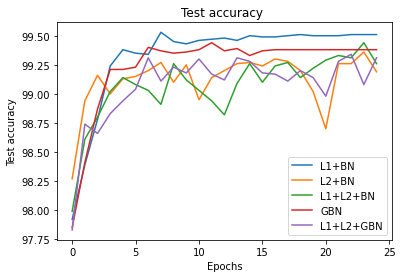

In [ ]:
plot_test_loss_accuracy(tracker)

In [ ]:
def plot_loss_change(tracker):
  for type_, d in tracker.items():
    for k, v in d.items():
      if k.lower() == "train_losses":
        x = [*range(len(v))]
        plt.plot(x, v, label=type_)

  plt.xlabel('Epochs')
  plt.ylabel('Train loss')
  plt.title('Train loss changes')
  plt.legend()    
  plt.plot()
  plt.savefig("fixed_s6_plot_train_loss_change.png", bbox_inches='tight')    

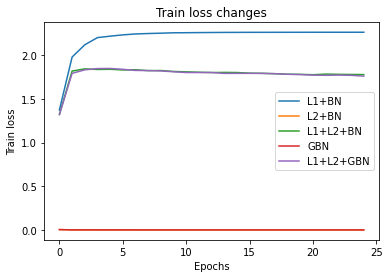

In [ ]:
plot_loss_change(tracker)

In [ ]:
def plot_test_loss_change(tracker):
  for type_, d in tracker.items():
    for k, v in d.items():
      if k.lower() == "test_losses":
        x = [*range(len(v))]
        plt.plot(x, v, label=type_)

  plt.xlabel('Epochs')
  plt.ylabel('Test loss')
  plt.title('Test loss changes')
  plt.legend()    
  plt.plot()
  plt.savefig("fixed_s6_plot_test_loss_change.png", bbox_inches='tight')    

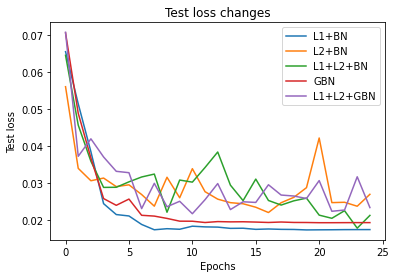

In [ ]:
plot_test_loss_change(tracker)

In [ ]:
def plot_misclassified(tracker):
  for type_, d in tracker.items():
    for k, v in d.items():
      if type_.lower() == "gbn" and k.lower() == "misclassified":
        fig = plt.figure(figsize = (10,10))
        for i in range(25):
              sub = fig.add_subplot(5, 5, i+1)
              plt.imshow(v[i][0].cpu().numpy().squeeze(),cmap='gray',interpolation='none')
              sub.set_title("Pred={}, Act={}".format(str(v[i][1].data.cpu().numpy()[0]),str(v[i][2].data.cpu().numpy())))
        plt.tight_layout()
        plt.show()
        plt.savefig("misclassified.png")

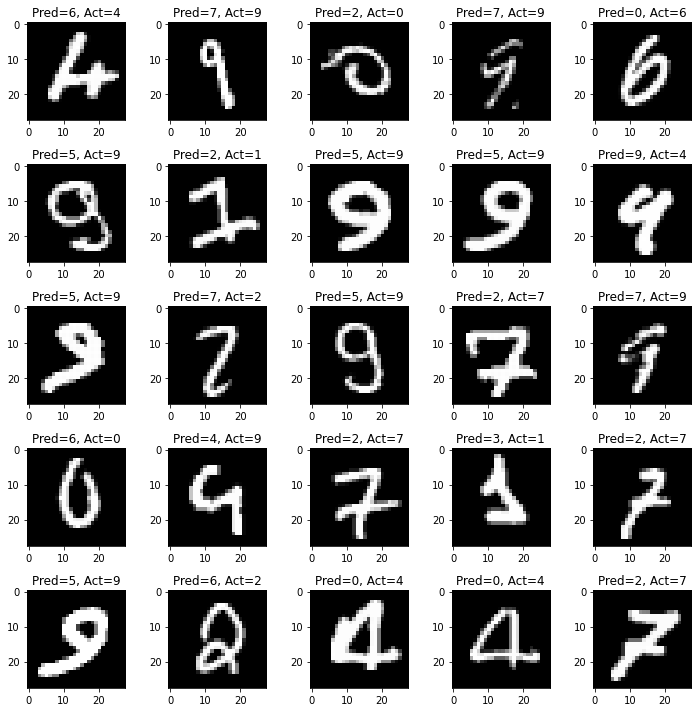

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_misclassified(tracker)